In [43]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('Top 10 stocks.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['000959.XSHE'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,11142.316912,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                  -1.625566
p-value                          0.469813
#Lags Used                       5.000000
Number of Observations Used    994.000000
Critical Value (1%)             -3.436946
Critical Value (5%)             -2.864452
Critical Value (10%)            -2.568321
dtype: float64


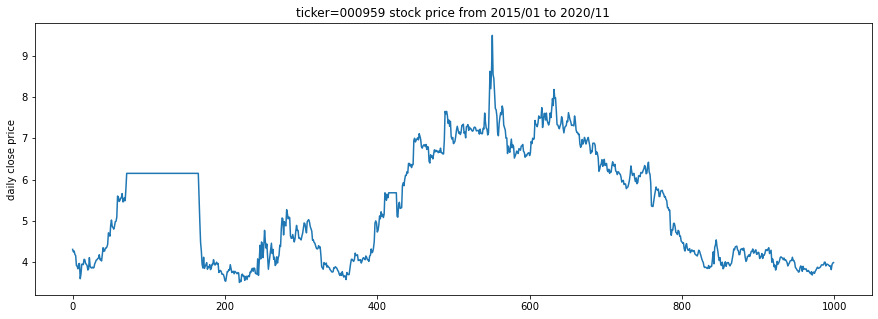

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=000959 stock price from 2015/01 to 2020/11')
plt.show()

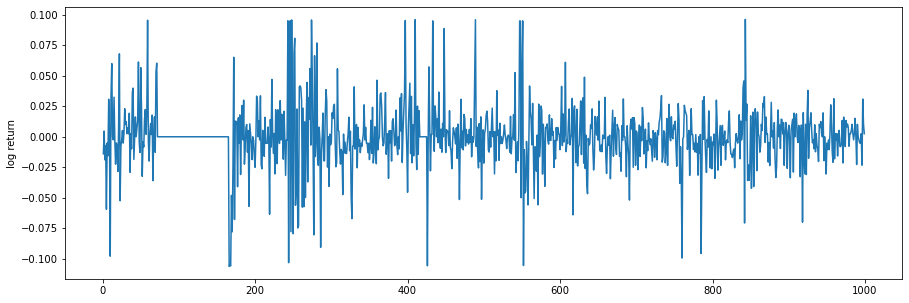

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.449375e+01
p-value                        6.088560e-27
#Lags Used                     4.000000e+00
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64


## ACF & PACF

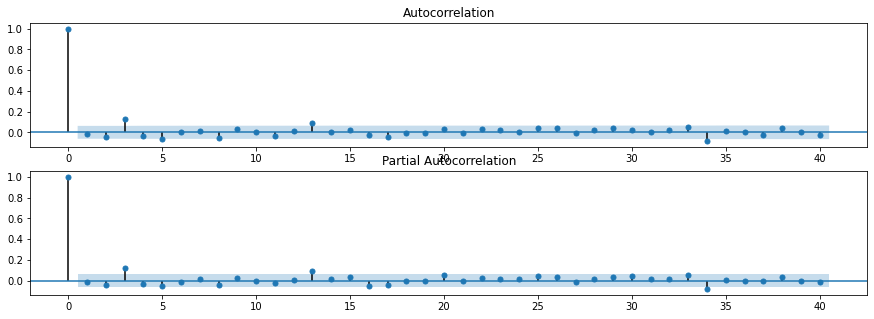

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

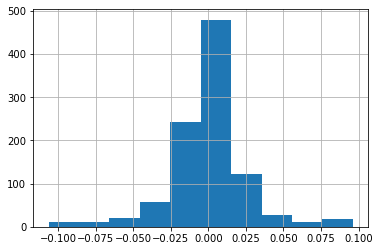

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [43]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    p = param[0]
    q = param[1]
    model = ARIMA(log_rtn, order=(p,0,q))
    
    model_fit = model.fit(disp=0)
    
    ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12], return_df=True).values[0][1]
    aic = model_fit.aic
    return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
16,3.0,2.0,0.989193,-4490.184557
14,3.0,0.0,0.847173,-4490.155367
12,2.0,3.0,0.987442,-4490.069298
17,3.0,3.0,0.983556,-4489.959137
19,4.0,0.0,0.925983,-4489.475982
2,0.0,3.0,0.772365,-4489.460067
20,4.0,1.0,0.986678,-4489.433063
3,0.0,4.0,0.899834,-4489.276442
8,1.0,4.0,0.971718,-4488.958252
15,3.0,1.0,0.892517,-4488.882167


## GARCH

In [13]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

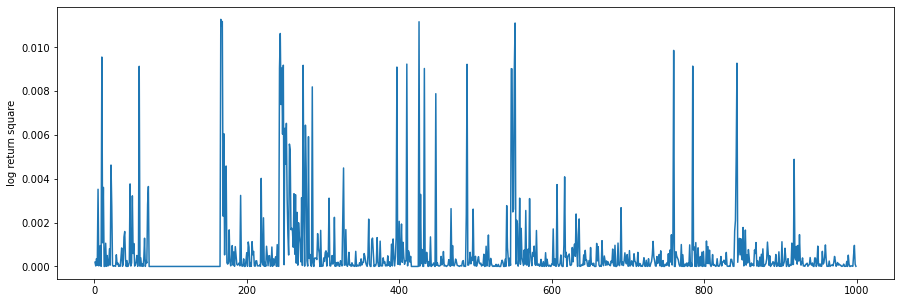

In [14]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [15]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.4740081657826085e-63
Conclusion: Has ARCH's property in log rtn


In [45]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2349.2801246170266
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2361.869867012789
            Iterations: 20
            Function evaluations: 153
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2359.8492695538494
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2346.23861417847
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2361.8698683415487
            Iterations: 17
            Function evalua

,p,q,alpha,beta,ljung_p,aic
1,1.0,2.0,0.169338,1.482298e-01,0.973494,-4713.739734
4,2.0,2.0,0.169360,1.482045e-01,0.973498,-4711.739737
7,3.0,2.0,0.169340,1.482071e-01,0.973491,-4709.739739
8,3.0,3.0,0.176233,8.941607e-14,0.986351,-4709.130313
2,1.0,3.0,0.200000,2.333332e-01,0.986913,-4707.698539
5,2.0,3.0,0.100107,2.333056e-01,0.986069,-4693.343577
0,1.0,1.0,0.200000,7.000001e-01,0.997178,-4690.560249
3,2.0,1.0,0.100000,7.000001e-01,0.995858,-4682.477228
6,3.0,1.0,0.080768,6.894250e-01,0.994491,-4677.133724
